In [ ]:
#from hybridpredictmaize22.hybridpredictmaize22.snpCompression import *
from hybridpredictmaize22.GEMlearn import *
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.snpCompression import *

from pathlib import Path
import os

import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.decomposition import PCA



from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn


In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler


#| export
class newGemDataset():
    """
    Pytorch Dataset which can be used with dataloaders for simple batching during training loops
    """
    def __init__(self,W,Y,G, def_device='cpu'):
        self.W = W
        self.SNP = G
        self.Y = Y
        self.device = def_device
        
    def __len__(self): return self.Y[0].shape[0]

    def __getitem__(self,idx):
      y = self.Y[0][idx]
      e = self.Y[1][idx]
      h = self.Y[2][idx]
      d = self.Y[3][idx]

      #weather
      w = self.W[1][np.where(self.W[0] == e)[0][0]]

      #snp
      g = snp_data[1][:,np.where(snp_data[0] == h)[0][0]]
      return y,g,w


#| export
class ST():
    """
    A class which will hold the secondary trait data for the entire dataset for pre-training purposes
    
    init
        yield_data -> pandas table
        testYear -> e.g. 2019. this will set all data from a given year as the Test Set
    """
    def __init__(self, yield_data, testYear):

        self.Te = yield_data.iloc[([str(testYear) in x for x in yield_data['Env']]),:].reset_index()
        self.Tr = yield_data.iloc[([str(testYear) not in x for x in yield_data['Env']]),:].reset_index()

        self.secondary_traits = [
                'Stand_Count_plants',
                'Pollen_DAP_days',
                'Silk_DAP_days',
                'Plant_Height_cm',
                'Ear_Height_cm',
                #'Root_Lodging_plants',
                #'Stalk_Lodging_plants',
                'Twt_kg_m3',
                'Yield_Mg_ha',
                #'Date_Harvested'
                ]
        
        self.setup_scaler()
        self.scale_data(self.Tr)
        self.scale_data(self.Te)

        self.make_arrays(self.Tr)
        self.make_arrays(self.Te, False)
    def setup_scaler(self):
        ss = MinMaxScaler()
        ss.fit(np.array(self.Tr[self.secondary_traits]))
        self.scaler = ss

    def scale_data(self,df):
        scaled_secondary = self.scaler.transform(np.array(df[self.secondary_traits]))
        for c,i in enumerate(self.secondary_traits):
            #print(i)
            df[i] = scaled_secondary[:,c]
    
    def plot_yields(self):
        for i in self.secondary_traits:
            plt.hist(self.Tr[i],density=True, label='Train',alpha=.5,bins=50)
            plt.hist(self.Te[i],density=True, label='Test',alpha=.5,bins=50)
            plt.legend()
            plt.title(i)
            plt.show()

    def make_arrays(self,df,train=True):
      df = np.array(df[self.secondary_traits]), np.array(df['Env']) , np.array(df['Hybrid']), np.array(df['Date_Planted'])
      if train:
        self.Tr = df
      else:
        self.Te= df

#| export
class newWT():
    """
    A class which will hold the weather data for the entire dataset for training purposes
    
    init
        weather_data -> pandas table
        testYear -> e.g. 2019. this will set all data from a given year as the Test Set
    """
    def __init__(self, weather_data, testYear):
        
        self.Te = weather_data.iloc[([str(testYear) in x for x in weather_data['Year']]),:].reset_index()
        self.Tr = weather_data.iloc[([str(testYear) not in x for x in weather_data['Year']]),:].reset_index()
            
        self.setup_scaler()
        self.scale_data(self.Tr)
        self.scale_data(self.Te)

        self.make_array(self.Tr)
        self.make_array(self.Te,False)
            
    def setup_scaler(self):
        ss = MinMaxScaler()
        ss.fit(self.Tr.select_dtypes('float'))
        self.scaler = ss
            
    def scale_data(self, df):
        fd = df.select_dtypes('float')
        fs = self.scaler.transform(fd)
        df[fd.columns] = fs

    def make_array(self, df,train = True):
      for c,i in enumerate(set(df['Env'])):
        env_weather = np.array(df[df['Env'] == i].iloc[:,4:-1])
        #print(env_weather.shape)
        if c == 0:
          env_order = list([i])
          weather_array =   np.array(df[df['Env'] == i].iloc[:,4:-1])
          weather_array = np.expand_dims(weather_array,axis=0)
        else:
          weather_array = np.vstack((weather_array, env_weather[None,:,:]))
          env_order.append(i)

        if train:
          self.Tr = (np.array(env_order), np.array(weather_array))
        else:
          self.Te = (np.array(env_order), np.array(weather_array))

In [ ]:
test_split = 2019
path_snps = Path('./data/snpCompress/')
data_path = Path('./data/Training_Data/')
path_train_weatherTable =data_path/'4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'1_Training_Trait_Data_2014_2021.csv'
snp_compression = 'PCS_100'
batch_size = 64

In [ ]:
path_train_yieldTable

Path('data/Training_Data/1_Training_Trait_Data_2014_2021.csv')

In [ ]:
!pwd

/mnt/c/Users/cltng/OneDrive/Documents/Projects/hybridpredictmaize22/dev_nbs


In [ ]:
snp_data = collect_snps(Path('./data/snpCompress/PCS_50')) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

In [ ]:
batch_size = 32


gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_data

tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

tr_dataloader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True)
te_dataloader = DataLoader(te_ds, batch_size=batch_size, shuffle=False)

<matplotlib.collections.PathCollection>

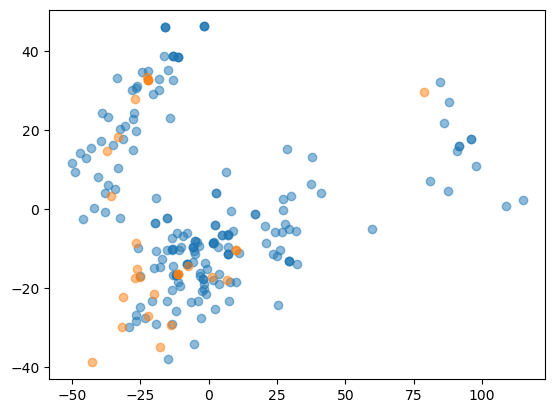

In [ ]:
wet = gem.W.Tr[1].reshape(184,5840)
test_wet = gem.W.Te[1].reshape(28,5840)
pca = PCA(n_components=2)
trwet = pca.fit_transform(wet)
tewet = pca.transform(test_wet)
plt.scatter(trwet[:,0], trwet[:,1],alpha=0.5)
plt.scatter(tewet[:,0], tewet[:,1],alpha=0.5)

In [ ]:
g_model = OneDCNN(2,4)
g_model = g_model

w_model = OneDCNN(2,1,kernel_size=7)
w_model = w_model

model = NNEnsemble2([50,50,1], [g_model,w_model])

TypeError: __init__() takes 1 positional argument but 3 were given

In [ ]:
test_split = 2019
test_year=2019

path_snps = Path('./data/snpCompress/')
data_path = Path('./data/Training_Data/')
path_train_weatherTable =data_path/'4_Training_Weather_Data_2014_2021.csv'
path_train_yieldTable = data_path/'1_Training_Trait_Data_2014_2021.csv'
snp_compression = 'PCS_100'
batch_size = 64

snp_data = collect_snps(Path('./data/snpCompress/PCS_50/')) # Read in the SNP profiles
yield_data = pd.read_csv(path_train_yieldTable) # Read in trait data 
yield_data = yield_data[yield_data['Yield_Mg_ha'].notnull()] #Remove plots w/ missing yields
weather_data = pd.read_csv(path_train_weatherTable) # Read in Weather Data
weather_data['Year'] = [x.split('_')[1] for x in weather_data['Env']] #Store Year in a new column
#removes yield data where no weather data
setYield = set(yield_data['Env'])
setWeather = set(weather_data['Env'])
only_yield = setYield - setWeather
only_weather = setWeather - setYield
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Env']],:]
#removes yield data where no genotype data
setSNP = set(snp_data[0])
setYield = set(yield_data['Hybrid'])
only_yield = setYield - setSNP
yield_data = yield_data.iloc[[x not in only_yield for x in yield_data['Hybrid']],:]

weather_data = remove_leapdays(weather_data)
weather_data = weather_data.reset_index()
yield_data=yield_data.sample(frac=1)
yield_data = yield_data.reset_index()

batch_size = 512

W = newWT(weather_data,test_year)
Y=ST(yield_data,test_year)

tr_gem = newGemDataset(W=W.Tr,
                    Y = Y.Tr,
                    G = snp_data)
te_gem = newGemDataset(W=W.Te,
                    Y= Y.Te,
                    G = snp_data)

# tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP, def_device='cpu')
# te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP, def_device ='cpu')

tr_dataloader = DataLoader(tr_gem, batch_size=batch_size, shuffle=True, num_workers=4)
te_dataloader = DataLoader(te_gem, batch_size=batch_size, shuffle=False, num_workers=4)

(array([2.1120e+03, 6.3440e+03, 1.7501e+04, 2.9331e+04, 3.0162e+04,
        1.5346e+04, 3.2320e+03, 2.7400e+02, 1.8000e+01, 4.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

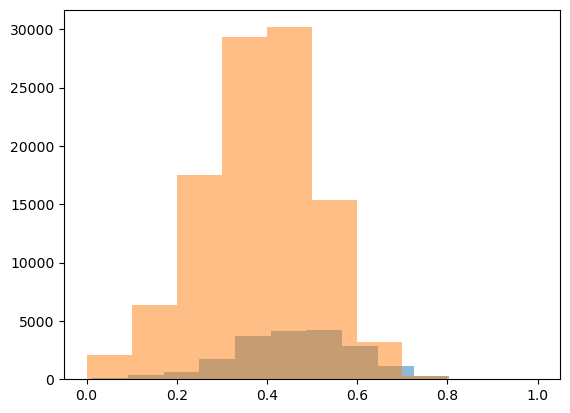

In [ ]:
plt.hist(Y.Te[0][:,-1],alpha=.5)
plt.hist(Y.Tr[0][:,-1],alpha=.5)

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])

    def forward(self, x):
        # Apply the dropout layer to the input
       #x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c == len(self.layers)-1:
              x = torch.nn.functional.linear(x)
            else: x = torch.nn.functional.relu(x)  
            
           # x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x

from torch.nn.modules.batchnorm import LazyBatchNorm1d
class OneDCNN(nn.Module):
    def __init__(self, num_layers, output_size, kernel_size = 2, pool_size = 2, batch=False):
        super(OneDCNN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()

        # create a stack of 1D convolutional, pooling, and batch normalization layers
        for _ in range(num_layers):
            self.layers.append((nn.LazyConv1d(output_size, kernel_size)))
            self.layers.append(nn.AdaptiveAvgPool1d(kernel_size))
            if batch:
              self.layers.append(nn.LazyBatchNorm1d(output_size))

    def forward(self, x):
        # apply the stack of layers to the input
        if x.dim() == 2:
          x = x.unsqueeze(1)
        for layer in self.layers:
            x = layer(x)
        return x


class NNEnsemble2(torch.nn.Module):
  def __init__(self, hidden_list, models_list):
    super().__init__()

    self.models = models_list

    self.layers = nn.ModuleList()

    for x in hidden_list:
      self.layers.append(nn.LazyLinear(x))


  def forward(self,x):
    g,w = x
    g = self.models[0](g)
    w = self.models[1](w)
    w = w.view(w.shape[0], w.shape[1] * w.shape[2])
    g = g.view(g.shape[0], g.shape[1] * g.shape[2])
    x = torch.concat((g,w),axis=1)
    for c,layer in enumerate(self.layers):
        x = layer(x)
        x = torch.nn.functional.relu(x)
    return x

def detach_list(torchlist):
  outs = []
  for i in torchlist:
    outs.append(i.cpu().detach().numpy()[0])
  return outs


def baseline_dl(te_dataloader, mean=None):
  get_y = []
  for y,g,w in te_dataloader:
    for i in y.cpu().detach().numpy():
      get_y.append(i[-1])

  if mean == None:
    mean = np.mean(get_y)
    avg = np.ones(len(get_y)) * mean
  else:
    avg = np.ones(len(get_y)) * mean

  print(f'mean is {mean} baseline is {loss_func(torch.tensor(get_y), torch.tensor(avg))}')


In [ ]:
batch_size

512

/home/burbank/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.90it/s]


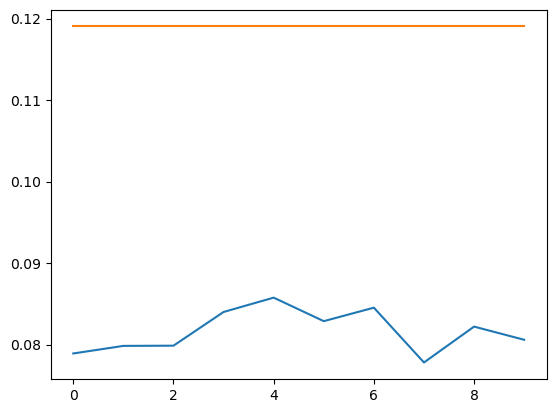

In [ ]:
#    def __init__(self, num_layers, output_size, kernel_size = 2, pool_size = 2, batch=False):


test_year=2019
tr_gem = newGemDataset(W=newWT(weather_data,test_year).Tr,
                    Y=ST(yield_data,test_year).Tr,
                    G = snp_data)
te_gem = newGemDataset(W=newWT(weather_data,test_year).Te,
                    Y=ST(yield_data,test_year).Te,
                    G = snp_data)

# tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP, def_device='cpu')
# te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP, def_device ='cpu')

tr_dataloader = DataLoader(tr_gem, batch_size=512, shuffle=True, num_workers=4)
te_dataloader = DataLoader(te_gem, batch_size=32, shuffle=False, num_workers=4)



g_model = OneDCNN(2,4)
g_model = g_model

w_model = OneDCNN(2,1,kernel_size=7)
w_model = w_model

model = NNEnsemble2([50,50,1], [g_model,w_model])

opt = optim.Adamax(model.parameters(), lr=.08)
#opt = optim.SGD(model.parameters(), lr=.08)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []

predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(10)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  
plt.plot(tr_loss)
plt.plot(te_loss)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


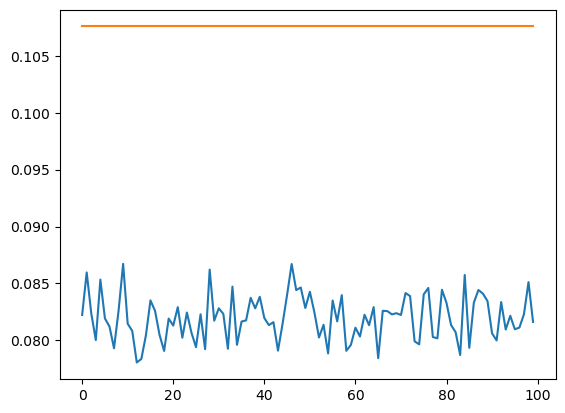

In [ ]:
#    def __init__(self, num_layers, output_size, kernel_size = 2, pool_size = 2, batch=False):


test_year=2019
tr_gem = newGemDataset(W=newWT(weather_data,test_year).Tr,
                    Y=ST(yield_data,test_year).Tr,
                    G = snp_data)
te_gem = newGemDataset(W=newWT(weather_data,test_year).Te,
                    Y=ST(yield_data,test_year).Te,
                    G = snp_data)

# tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP, def_device='cpu')
# te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP, def_device ='cpu')

tr_dataloader = DataLoader(tr_gem, batch_size=512, shuffle=True, num_workers=4)
te_dataloader = DataLoader(te_gem, batch_size=32, shuffle=False, num_workers=4)



opt = optim.SGD(model.parameters(), lr=.08)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []

predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(100)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  
plt.plot(tr_loss)
plt.plot(te_loss)
plt.show()

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])

    def forward(self, x):
        # Apply the dropout layer to the input
        #x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        if x.dim() == 3:
            x = x.view(x.shape[0], x.shape[1]*x.shape[2])
        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c < len(self.layers)-1:
              x = torch.nn.functional.relu(x)  
            
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x

class CNN1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool_size, num_layers, flat=True):
        super(CNN1D, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        self.flat = flat
        for i in range(num_layers):
            self.conv_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size))
            self.pool_layers.append(nn.AvgPool1d(pool_size))
            in_channels = out_channels

    def forward(self, x):

        if x.dim() == 2: x = x.view(x.shape[0],1,x.shape[1])

        for conv, pool in zip(self.conv_layers, self.pool_layers):
            x = pool(conv(x))
        
        if self.flat:
          x = x.view(x.shape[0], x.shape[1]*x.shape[2])
          
        return x



class NNEnsemble(torch.nn.Module):
  def __init__(self, hidden_list, models_list, dummy, alpha=None):
    super().__init__()

    self.models = models_list

    self.layers = nn.ModuleList()

    for x in hidden_list:
      self.layers.append(nn.LazyLinear(x))

    
    if alpha != None:
        x = dummy
        for c,l in enumerate(self.layers):
            x = l(torch.rand)
            torch.nn.init.xavier_normal_(l.weight,gain=hidden_list[0] / 100)
    self.out = nn.LazyLinear(1)

  def forward(self,x):
    g,w = x
    g = self.models[0](g)
    w = self.models[1](w)

    if w.dim() == 3:
      w = w.view(w.shape[0], w.shape[1] * w.shape[2])
    x = torch.concat((g,w),axis=1)
    for c,layer in enumerate(self.layers):
      x = layer(x)
      x = torch.nn.functional.relu(x) 
    return self.out(x)

In [ ]:
torch.rand(100,10).shape

torch.Size([100, 10])

In [ ]:
g.shape

torch.Size([32, 500])

In [ ]:
w.shape

torch.Size([32, 365, 16])

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dummy, alpha=None, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])
        
        
        if alpha != None:
            x = dummy
            for l in self.layers:
                if x.dim() == 3:
                    x = x.view(x.shape[0], x.shape[1]*x.shape[2])

                x = l(x)
                torch.nn.init.xavier_normal_(l.weight,gain=hidden_list[0] / 100)

            

    def forward(self, x):
        # Apply the dropout layer to the input
        #x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        if x.dim() == 3:
            x = x.view(x.shape[0], x.shape[1]*x.shape[2])
        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c < len(self.layers)-1:
              x = torch.nn.functional.relu(x)  
            
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x
    
    

class NNEnsemble(torch.nn.Module):
  def __init__(self, hidden_list, models_list, alpha=None):
    super().__init__()

    self.models = models_list

    self.layers = nn.ModuleList()
    self.lin1 = torch.nn.Linear(hidden_list[0], hidden_list[1])
    self.lin2 = torch.nn.Linear(hidden_list[1], hidden_list[2])
    self.out = torch.nn.Linear(hidden_list[2], 1)

    
    if alpha != None:
        print('X')
        for c,l in enumerate(self.layers):
            print(l)
            torch.nn.init.xavier_normal_(l.weight,gain=alpha)
    self.out = nn.LazyLinear(1)

  def forward(self,x):
    g,w = x
    g = self.models[0](g)
    w = self.models[1](w)

    if w.dim() == 3:
      w = w.view(w.shape[0], w.shape[1] * w.shape[2])
    x = torch.concat((g,w),axis=1)
    for c,layer in enumerate(self.layers):
      x = layer(x)
      x = torch.nn.functional.relu(x) 
    return self.out(x)

X


(array([ 1.,  3.,  3., 10.,  2.,  4.,  5.,  1.,  2.,  1.]),
 array([-0.46105206, -0.31324443, -0.16543682, -0.0176292 ,  0.13017842,
         0.27798605,  0.42579368,  0.57360131,  0.7214089 ,  0.86921656,
         1.01702416]),
 <BarContainer object of 10 artists>)

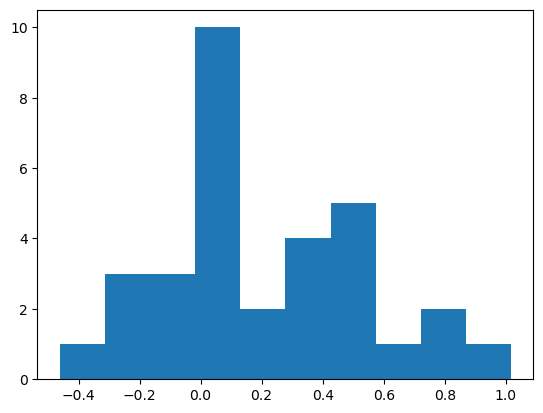

In [ ]:
gmodel = LazyMLP([500,500,200],g,2)
wmodel = LazyMLP([5840,1000,250],w)
model = NNEnsemble([500,500,500], [gmodel,wmodel],alpha=5)
plt.hist(detach_list(model((g,w))))

In [ ]:
next(iter(tr_dataloader))[0].shape

torch.Size([512, 7])

100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [32:14<00:00,  1.29s/it]


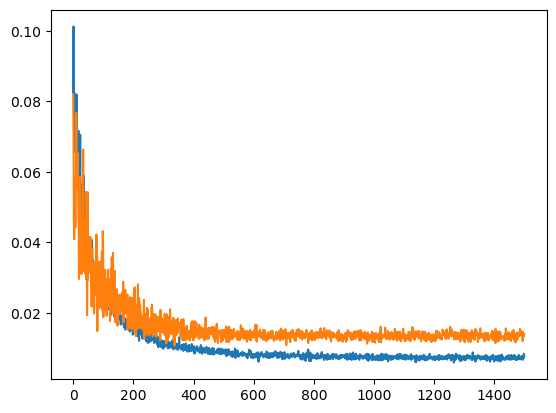

104324 104324


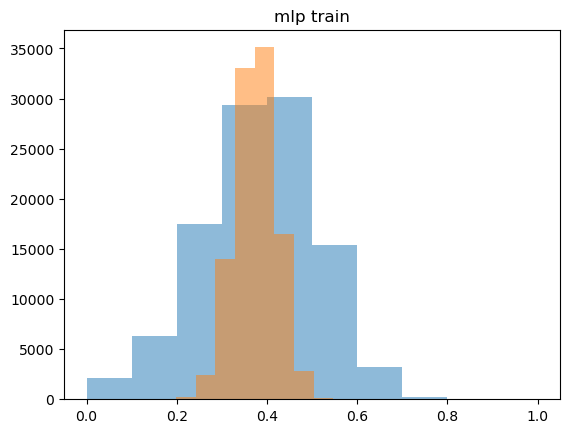

19193 19193


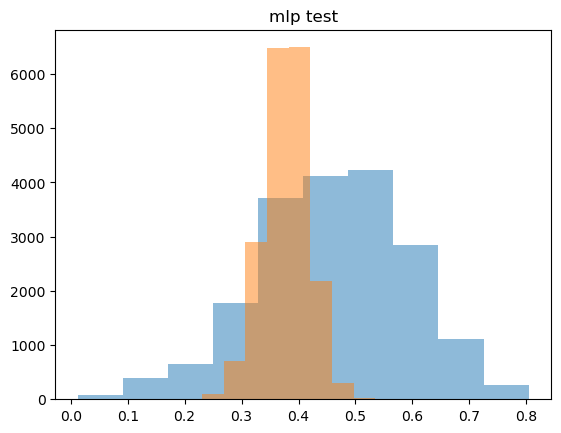

In [ ]:
# gmodel = LazyMLP([500,50,25],g,2)
# wmodel = LazyMLP([5840,50,15],w)
# model = NNEnsemble([200,50,25], [gmodel,wmodel])
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.0005, weight_decay=.00001)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []

predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(1500)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  
plt.plot(tr_loss)
plt.plot(te_loss)
plt.show()

runover(model, tr_dataloader, 'mlp train')
runover(model, te_dataloader, 'mlp test')

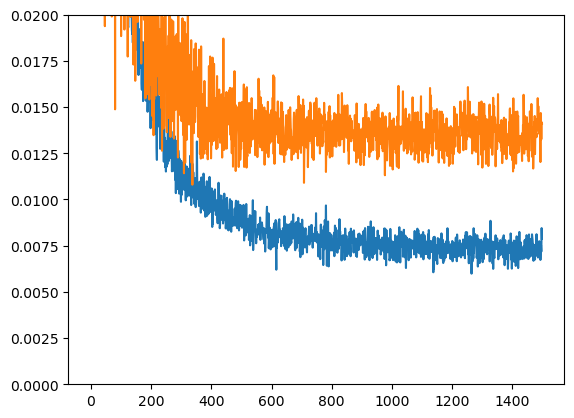

In [ ]:

  
plt.plot(tr_loss)
plt.plot(te_loss)
plt.ylim(0,.02)
plt.show()

In [ ]:
baseline_dl(te_dataloader)

mean is 0.4608543245973794 baseline is 0.008660840736751333


In [ ]:
preds

tensor([0.4517, 0.3224, 0.4093, 0.3190, 0.3943, 0.3977, 0.3819, 0.3399, 0.3879,
        0.4041, 0.3654, 0.3854, 0.4345, 0.3959, 0.3750, 0.3773, 0.3509, 0.3458,
        0.3611, 0.3974, 0.3373, 0.3711, 0.3918, 0.3690, 0.3634, 0.3715, 0.4109,
        0.3481, 0.3581, 0.3546, 0.3973, 0.3937], grad_fn=<SqueezeBackward1>)

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [01:20<00:00,  2.53it/s]


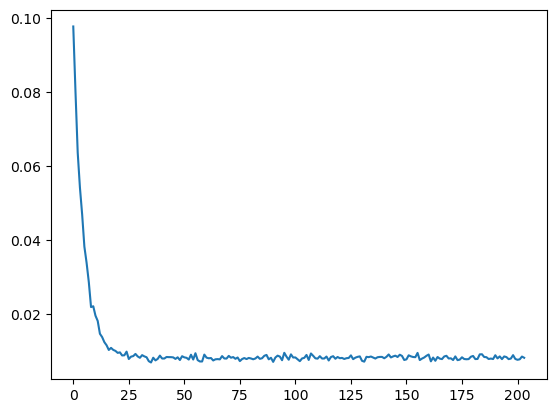

104324 104324


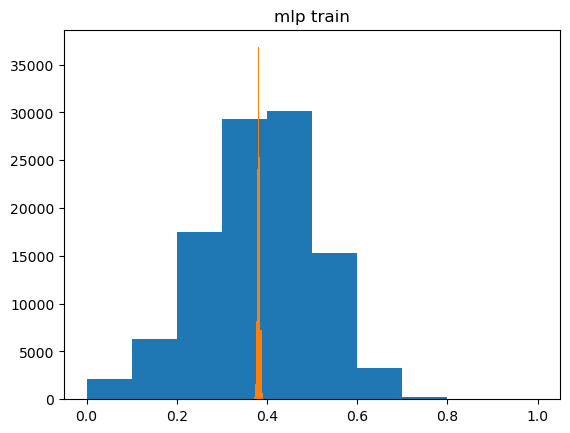

In [ ]:
gmodel = LazyMLP([500,2000,1000])
wmodel = LazyMLP([5840,2000,1000])
model = NNEnsemble([2000,500,1], [gmodel,wmodel])

opt = optim.SGD(model.parameters(), lr=.08)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []

predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for y,g,w in tqdm(tr_dataloader):
  model.eval()
  #train loop
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  
plt.plot(tr_loss)
#plt.plot(te_loss)
plt.show()

runover(model, tr_dataloader, 'mlp train')

In [ ]:
def runover(model,dl, title):
    predicts = []
    targets = []
    for y,g,w in dl:
        y =  y[:,-1]
        y = y.to(torch.float32)
        g = g.to(torch.float32)
        w = w.to(torch.float32)

        preds = model((g,w))

        for i in preds:
            predicts.append(i.cpu().detach().numpy()[0])
        for i in y:
            targets.append(i.cpu().detach().numpy())

    print(len(targets), len(predicts))
    plt.hist(targets,alpha=.5)
    plt.hist(predicts,alpha=.5)
    plt.title(title)
    plt.show()
   

104324 104324


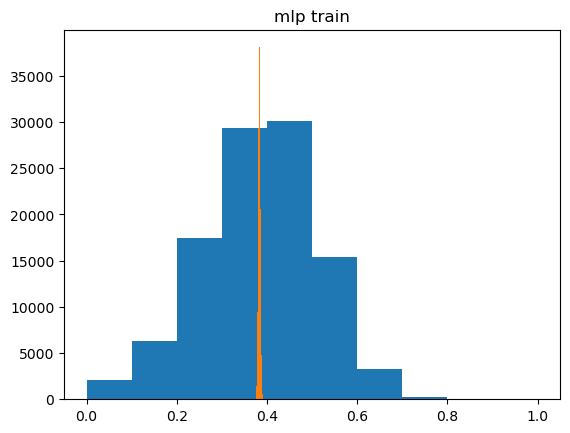

In [ ]:
runover(model, tr_dataloader, 'mlp train')

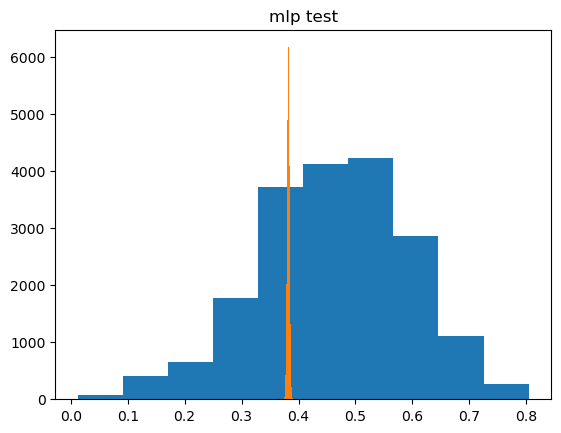

In [ ]:
runover(model, te_dataloader, 'mlp test')

In [ ]:
preds

tensor([0.3817, 0.3827, 0.3833, 0.3794, 0.3831, 0.3812, 0.3791, 0.3876, 0.3816,
        0.3827, 0.3825, 0.3840, 0.3838, 0.3857, 0.3786, 0.3817, 0.3866, 0.3790,
        0.3838, 0.3806, 0.3797, 0.3793, 0.3809, 0.3828, 0.3827, 0.3821, 0.3850,
        0.3810, 0.3775, 0.3851, 0.3811, 0.3874], grad_fn=<SqueezeBackward1>)

In [ ]:
def moving_average(arr, window_size):
    """Calculate the moving average of an array.
    
    Parameters:
    arr (np.ndarray): Input array with shape (n_samples,).
    window_size (int): Size of the moving window.
    
    Returns:
    np.ndarray: Moving average of the array, with shape (n_samples - window_size + 1,).
    """
    # Initialize a NumPy array to store the moving averages
    ma = np.zeros(len(arr) - window_size + 1)
    
    # Calculate the moving average
    for i in range(len(ma)):
        ma[i] = np.mean(arr[i:i+window_size])
        
    return ma


[<matplotlib.lines.Line2D>]

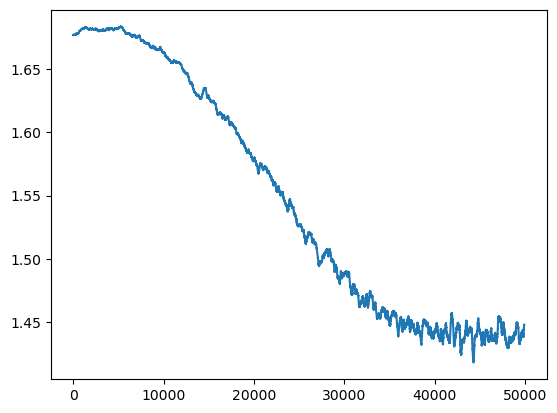

In [ ]:
plt.plot(moving_average(te_loss,100))

[<matplotlib.lines.Line2D>]

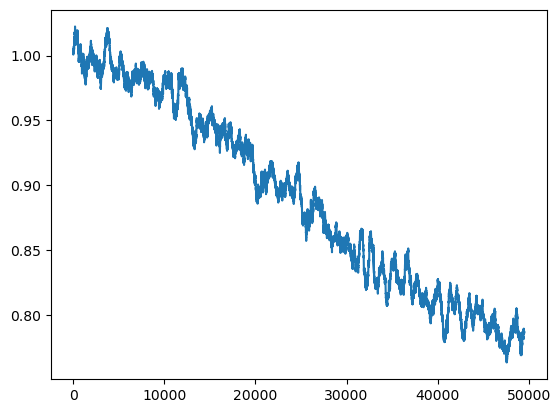

In [ ]:
plt.plot(moving_average(tr_loss,500))

In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        self.cb_ctx = partial(callback_ctx, self.callback)
        fc.store_attr()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
class LazyMLP(torch.nn.Module):
    def __init__(self, hidden_list, dropout=0.1):
        super().__init__()
        self.dropout = dropout

        # Create a list of linear layers, with the correct input and output dimensions
        self.layers = torch.nn.ModuleList([nn.LazyLinear(x) for x in hidden_list])

    def forward(self, x):
        # Apply the dropout layer to the input
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        # Iterate through the linear layers, applying each one to the input
        for c, layer in enumerate(self.layers):
            x = layer(x)
            
            if c < len(self.layers)-1:
              x = torch.nn.functional.relu(x)  
            
            x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)

        return x

In [ ]:
model = LazyMLP([500,10,1])

/home/burbank/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
class TrainCB(Callback):
    def predict(self, learn):
        learn.preds = learn.model(learn.batch[1])
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds.squeeze(), learn.batch[0])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
y,g,w = next(iter(tr_dataloader))

In [ ]:
learn = Learner(model, dls, cbs = [TrainCB()])

In [ ]:
learn.fit(1)

In [ ]:
learn.model(g)

tensor([[-0.4786],
        [-0.7224],
        [-0.5547],
        [-0.2708],
        [-0.3547],
        [-0.6647],
        [-0.3344],
        [-0.4365],
        [-0.4018],
        [-0.5777],
        [-0.6922],
        [-0.3879],
        [-0.3761],
        [-0.3826],
        [-0.3891],
        [-0.5835],
        [-0.1854],
        [-0.7585],
        [-0.5328],
        [-0.3824],
        [-0.4994],
        [-0.4323],
        [-0.5865],
        [-0.2736],
        [-0.3865],
        [-0.2693],
        [-0.7051],
        [-0.4338],
        [-0.5399],
        [-0.6746],
        [-0.6584],
        [-0.5087]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch
import torch.nn as nn

class EfficientNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes=1):
        super(EfficientNet, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(128)


        # Define the depthwise separable convolutional layers
        self.dwconv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn4 = nn.BatchNorm1d(128)

        # Define the fully connected layer
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        # Pass the input through the convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)


        # Pass the input through the depthwise separable convolutional layers
        x = self.dwconv1(x)
        x = self.bn4(x)
        x = F.relu(x)

        # Flatten the feature maps before passing them through the fully connected layer
        #x = x.view(-1, 128)
        #x = self.fc(x)

        return x

In [ ]:
tm = EfficientNet2()
tm(g).shape

torch.Size([32, 128, 63])

In [ ]:
tm = EfficientNet2(365)
tm(w).shape

torch.Size([32, 128, 2])

(array([1., 0., 0., 0., 1., 9., 5., 5., 7., 4.]),
 array([-0.84637028, -0.6823622 , -0.51835418, -0.3543461 , -0.19033803,
        -0.02632996,  0.1376781 ,  0.30168617,  0.46569422,  0.62970227,
         0.79371035]),
 <BarContainer object of 10 artists>)

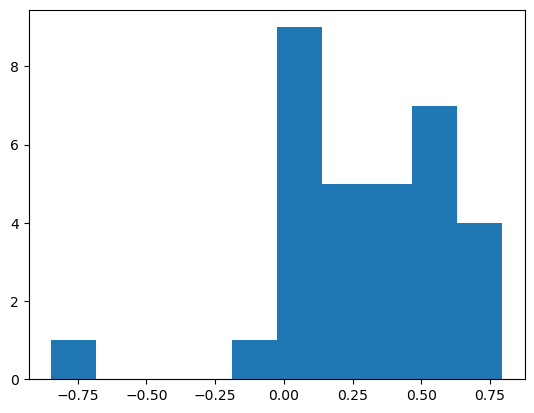

In [ ]:
class EfficientNet2(nn.Module):
    def __init__(self, in_chan = 1 , num_classes=100):
        super(EfficientNet2, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_chan, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm1d(128)

        # Define the depthwise separable convolutional layers
        self.dwconv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False)
        self.bn4 = nn.BatchNorm1d(128)

        self.dwconv2 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding=1, groups=128, bias=False)
        self.bn5 = nn.BatchNorm1d(128)

        # Define the fully connected layer
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass the input through the convolutional layers
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Pass the input through the depthwise separable convolutional layers
        x = self.dwconv1(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.dwconv2(x)
        x = self.bn5(x)
        x = F.relu(x)

        # Flatten the feature maps before passing them through the fully connected layer
        # x = x.view(-1, 128)
        # x = self.fc(x)

        return x
    
class EfficientNet3(nn.Module):
    def __init__(self, in_chan = 1 , num_classes=100):
        super(EfficientNet2, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_chan, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm1d(128)

        # Define the depthwise separable convolutional layers
        self.dwconv1 = nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm1d(128)

        self.dwconv2 = nn.Conv1d(128, 128, kernel_size=3, stride=2, padding=1,  bias=False)
        self.bn5 = nn.BatchNorm1d(128)

        # Define the fully connected layer
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pass the input through the convolutional layers
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Pass the input through the depthwise separable convolutional layers
        x = self.dwconv1(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.dwconv2(x)
        x = self.bn5(x)
        x = F.relu(x)

        # Flatten the feature maps before passing them through the fully connected layer
        # x = x.view(-1, 128)
        # x = self.fc(x)

        return x

class NNEnsemble3(torch.nn.Module):
  def __init__(self, hidden_list, models_list, alpha=None):
    super().__init__()

    self.models = models_list

    self.layers = nn.ModuleList()
    self.lin1 = torch.nn.Linear(hidden_list[0], hidden_list[1])
    self.lin2 = torch.nn.Linear(hidden_list[1], hidden_list[2])
    self.out = torch.nn.Linear(hidden_list[2], 1)

    
    if alpha != None:
        print('X')
        for c,l in enumerate(self.layers):
            print(l)
            torch.nn.init.xavier_normal_(l.weight,gain=alpha)
    self.out = nn.LazyLinear(1)

  def forward(self,x):
    g,w = x
    g = self.models[0](g)
    w = self.models[1](w)
 #   print(g.shape, w.shape)

    if w.dim() == 3:
      w = w.view(w.shape[0], w.shape[1] * w.shape[2])
    if g.dim() == 3:
      g = g.view(g.shape[0], g.shape[1] * g.shape[2])

    x = torch.concat((g,w),axis=1)
    for c,layer in enumerate(self.layers):
      x = layer(x)
      x = torch.nn.functional.relu(x) 
    return self.out(x)

In [ ]:
gm = EfficientNet2(num_classes=2500)
wm = EfficientNet2(365, num_classes=2500)
                    

model = NNEnsemble3([2000,1000,500], [gm,wm],alpha=2)
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.0002, weight_decay=.001)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []
te_MA = []
predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(2500)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  if i > 15:
    te_MA.append(moving_average(te_loss[i-15:],14)[-1])

    if i > 80:
        if ((te_MA[-int(round((0.5 * len(te_loss)),1))] < te_loss[i])):
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()

            break

  
  
# plt.plot(tr_loss)
# plt.plot(te_loss)
# plt.show()

# runover(model, tr_dataloader, 'mlp train')
# runover(model, te_dataloader, 'mlp test')

X


100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [52:52<00:00,  1.27s/it]


In [ ]:
runover(model, tr_dataloader, 'cnn train')
runover(model, te_dataloader, 'cnn test')

In [ ]:
round(15.2,0)

15.0

In [ ]:
(te_MA[-35] - te_loss[i])

IndexError: list index out of range

In [ ]:
((te_MA[-35] - te_loss[i])) / te_MA[-35]

IndexError: list index out of range

In [ ]:
te_loss

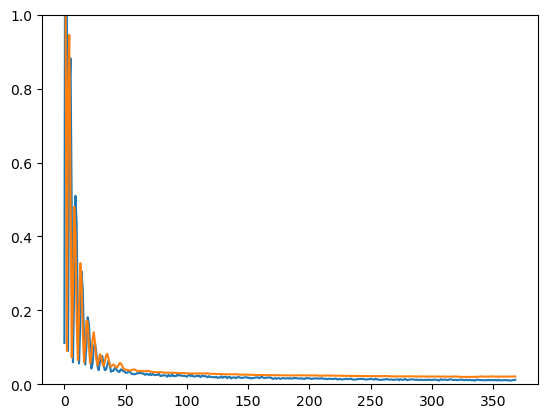

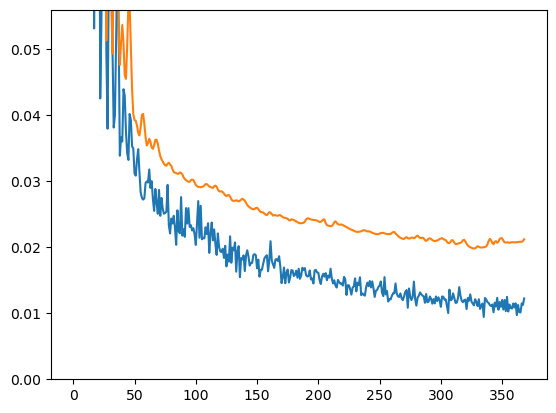

In [ ]:
  
plt.plot(tr_loss)
plt.plot(te_loss)
plt.ylim(0,1)
plt.show()

plt.ylim(0,.056)
plt.plot(tr_loss)
plt.plot(te_loss)
plt.show()


In [ ]:
baseline_dl(te_dataloader)

mean is 0.4608543245973794 baseline is 0.008660840736751333


In [ ]:
baseline_dl(tr_dataloader)

mean is 0.38379425680013957 baseline is 0.008036697448253824


In [ ]:
gm = EfficientNet2(num_classes=2500)
wm = EfficientNet2(365, num_classes=2500)
                    

model = NNEnsemble3([2000,1000,500], [gm,wm],alpha=2)
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.0002, weight_decay=.0001)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []
te_MA = []
predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(7500)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  if i > 15:
    te_MA.append(moving_average(te_loss[i-15:],14)[-1])

    if i > 80:
        if ((te_MA[-int(round((0.35 * len(te_loss)),1))] < te_loss[i])):
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()

            break

  
  
# plt.plot(tr_loss)
# plt.plot(te_loss)
# plt.show()

runover(model, tr_dataloader, 'cnn train')
runover(model, te_dataloader, 'cnn test')

In [ ]:
gm = EfficientNet2(num_classes=2500)
wm = EfficientNet2(365, num_classes=2500)
                    

model = NNEnsemble3([2000,1000,500], [gm,wm],alpha=2)
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.00005, weight_decay=.0001)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []
te_MA = []
predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(10500)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  if i > 15:
    te_MA.append(moving_average(te_loss[i-15:],14)[-1])

    if i > 80:
        if ((te_MA[-int(round((0.35 * len(te_loss)),1))] < te_loss[i])):
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()

            break

  
  
# plt.plot(tr_loss)
# plt.plot(te_loss)
# plt.show()

runover(model, tr_dataloader, 'cnn train')
runover(model, te_dataloader, 'cnn test')

In [ ]:
gm = EfficientNet2(num_classes=1500)
wm = EfficientNet2(365, num_classes=1500)
                    

model = NNEnsemble3([2000,1000,1000], [gm,wm],alpha=2)
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.00005, weight_decay=.001)
loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []
te_MA = []
predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(10500)):
  model.eval()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()

  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())



  if i > 15:
    te_MA.append(moving_average(te_loss[i-15:],14)[-1])

    if i > 80:
        if ((te_MA[-int(round((0.35 * len(te_loss)),1))] < te_loss[i])):
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()

            break

  
  
# plt.plot(tr_loss)
# plt.plot(te_loss)
# plt.show()

runover(model, tr_dataloader, 'cnn train')
runover(model, te_dataloader, 'cnn test')

  0%|                                                                                 | 1/2500 [00:00<33:04,  1.26it/s]

0 tensor(0.0179, grad_fn=<HuberLossBackward0>)


  4%|███▏                                                                           | 101/2500 [01:15<29:03,  1.38it/s]

100 tensor(0.0173, grad_fn=<HuberLossBackward0>)


  5%|████                                                                           | 127/2500 [01:35<31:48,  1.24it/s]

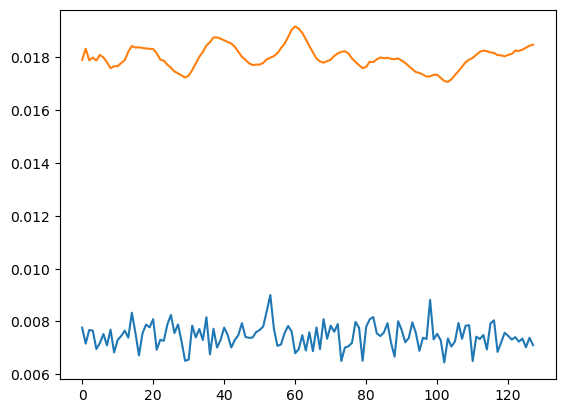


early
0.01848076


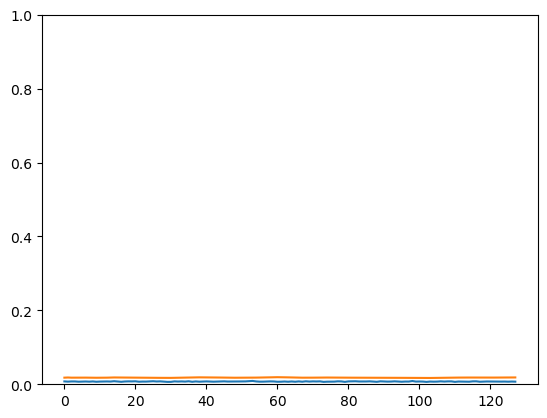

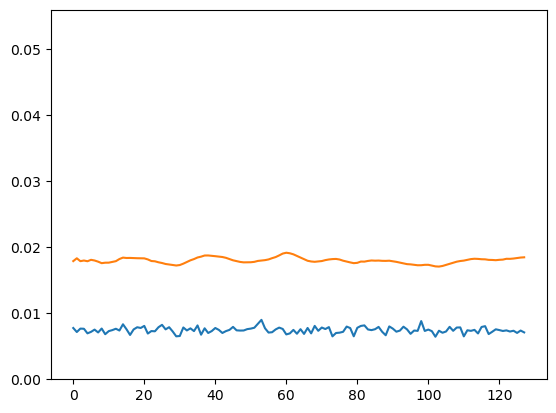

  5%|████                                                                           | 127/2500 [01:36<30:03,  1.32it/s]


104324 104324


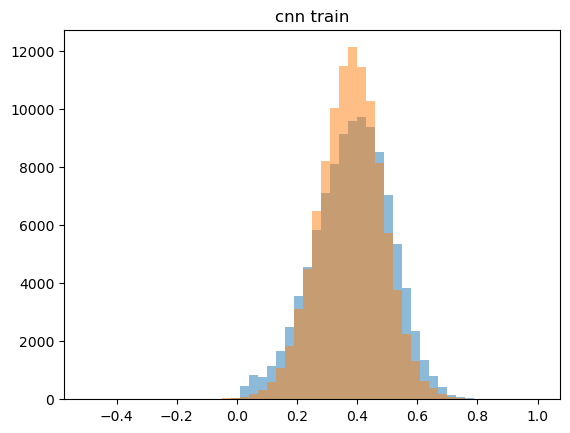

19193 19193


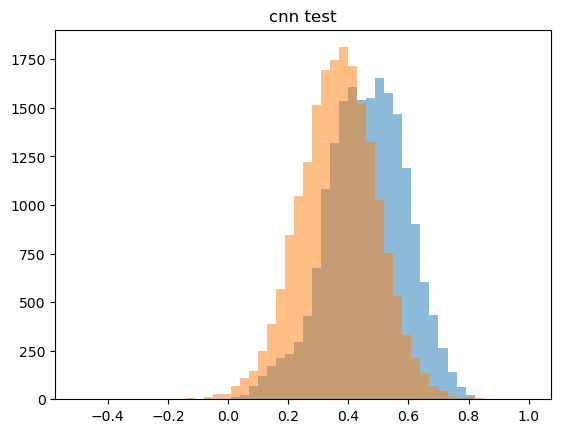

In [ ]:
gm = EfficientNet2(num_classes=1500)
wm = EfficientNet2(365, num_classes=1500)
                    

#model = NNEnsemble3([2000,1000,1000], [gm,wm],alpha=2)
# plt.hist(detach_list(model((g,w))))

opt = optim.Adamax(model.parameters(), lr=.00001, weight_decay=.001)
#scheduler =  optim.lr_scheduler.ReduceLROnPlateau(opt)

loss_func = torch.nn.functional.huber_loss

tr_loss = [] 
te_loss = []
te_MA = []
predicts = []
targets = []

#for i in tqdm(range(len(tr_dataloader))):
for i in tqdm(range(2500)):
  model.train()
  #train loop
  y,g,w = next(iter(tr_dataloader))
  y =  y[:,-1]
  y = y.type(torch.float32)
  g = g.type(torch.float32)
  w = w.type(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y, preds)

  loss.backward()
  opt.step()
  opt.zero_grad()
  scheduler.step(loss)
  tr_loss.append(loss.cpu().detach().numpy())


  #test loop
  model.eval()
  y,g,w = next(iter(te_dataloader))
  y =  y[:,-1]
  y = y.to(torch.float32)
  g = g.to(torch.float32)
  w = w.to(torch.float32)

  preds = model((g,w))
  preds = preds.squeeze(1)

  loss = loss_func(y,preds)

  te_loss.append(loss.cpu().detach().numpy())

  if i % 100 == 0:
    print(i, loss)

  if i > 15:
    te_MA.append(moving_average(te_loss[i-15:],14)[-1])

    if i > 80:
        if ((te_MA[-int(round((0.45 * len(te_loss)),1))] < te_loss[i])):
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()

            break

  
  
# plt.plot(tr_loss)
# plt.plot(te_loss)
# plt.show()

runover(model, tr_dataloader, 'cnn train')
runover(model, te_dataloader, 'cnn test')

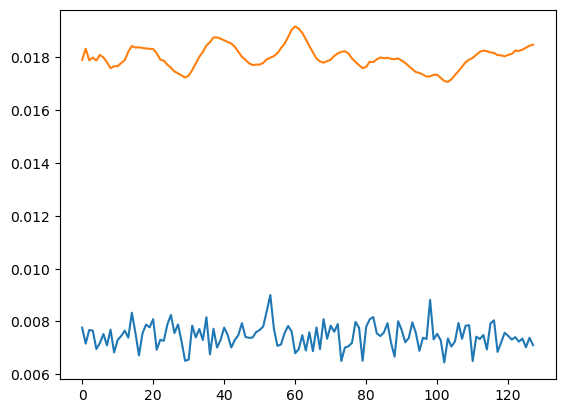


early
0.01848076


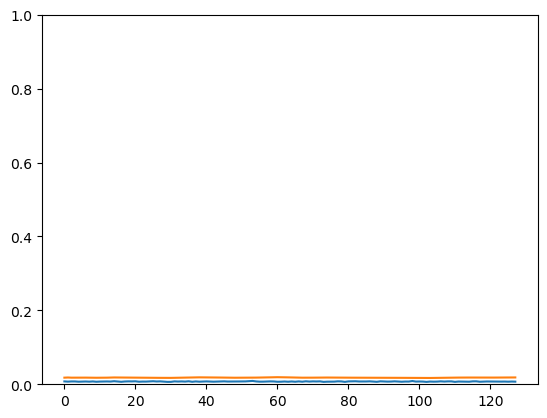

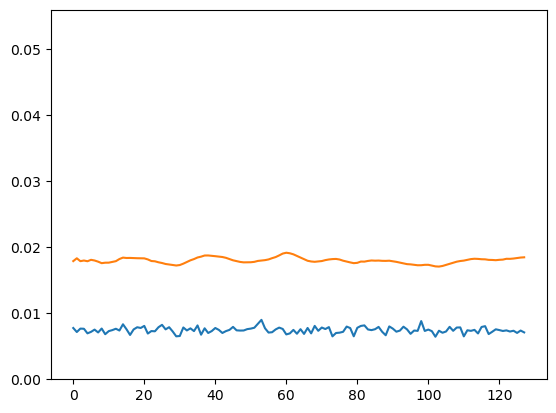

In [ ]:
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()
            print('')
            print('early')
            print(te_loss[-1])

            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.ylim(0,1)
            plt.show()

            plt.ylim(0,.056)
            plt.plot(tr_loss)
            plt.plot(te_loss)
            plt.show()


104324 104324


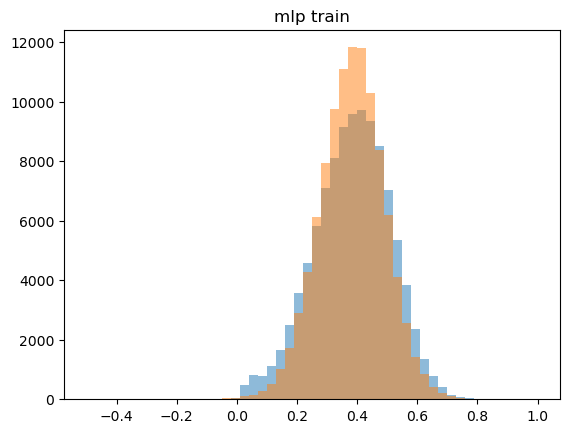

19193 19193


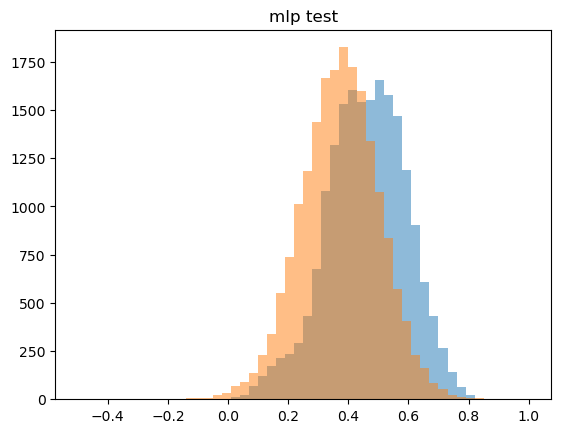

In [ ]:
runover(model, tr_dataloader, 'mlp train')
runover(model, te_dataloader, 'mlp test')

In [ ]:
baseline_dl(te_dataloader)

mean is 0.4608543245973794 baseline is 0.008660840736751333


In [ ]:
def runover(model,dl, title, bins=50):
    predicts = []
    targets = []
    for y,g,w in dl:
        y =  y[:,-1]
        y = y.to(torch.float32)
        g = g.to(torch.float32)
        w = w.to(torch.float32)

        preds = model((g,w))

        for i in preds:
            predicts.append(i.cpu().detach().numpy()[0])
        for i in y:
            targets.append(i.cpu().detach().numpy())

    print(len(targets), len(predicts))
    plt.hist(targets,alpha=.5,range=(-.5,1),bins=bins)
    plt.hist(predicts,alpha=.5,range=(-.5,1),bins=bins)
    plt.title(title)
    plt.show()
   

19193 19193


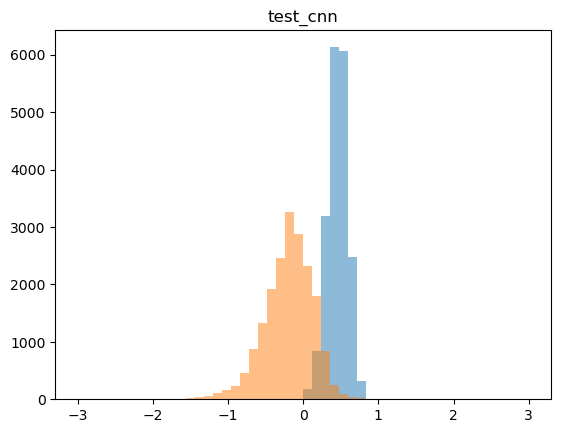

In [ ]:
runover(modelE, te_dataloader,'test_cnn')